> dynamic Classifier-free Guidance across several Diffusion models.

# Introduction

This notebook is Part 7 in a [series](https://enzokro.dev/blog/posts/2022-11-15-guidance-expts-6/) on dynamic Classifier-free Guidance. It checks whether our best schedule and normalization improve the generated images across Diffusion models.

## Recap of Parts 1-6

The first six parts found a good set of schedules and normalizations for a dynamic Classifier-free Guidance.

## Part 7: Improvement across models

Part 7 takes our best schedule so far, `Inverse kDecay` with $k = 0.15$, and tries it with a few different models:  

- Stable Diffusion v1-4
- Stable Diffusion v1-5
- openjourney
- Stable Diffusion 2-base

# Python imports

We start with a few python imports.

In [ ]:
import os
import random
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## Seed for reproducibility

`seed_everything` makes sure that the results are reproducible across notebooks.

In [ ]:
# set the seed and pseudo random number generator
SEED = 894630702
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    generator = torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return generator

# for sampling the initial, noisy latents
generator = seed_everything(SEED)

# Cosine schedules with k-decay

We create the schedules with different $k$ values using the `cf_guidance` library.

In [ ]:
# helpers to create cosine schedules
from cf_guidance.schedules  import get_cos_sched

# normalizations for classifier-free guidance
from cf_guidance.transforms import GuidanceTfm, BaseNormGuidance, TNormGuidance, FullNormGuidance

For the other schedule parameters, we keep the [same values](https://enzokro.dev/blog/posts/2022-11-20-guidance-expts-2/#default-schedule-parameters) from the rest of the series. The functions below are also shared with previous notebooks. 

In [ ]:
# Default schedule parameters from the blog post
######################################
max_val           = 7.5   # guidance scaling value
min_val           = 1.    # minimum guidance scaling
num_steps         = 50    # number of diffusion steps
num_warmup_steps  = 0     # number of warmup steps
warmup_init_val   = 0     # the intial warmup value
num_cycles        = 0.5   # number of cosine cycles
k_decay           = 1     # k-decay for cosine curve scaling 

# smaller values for T-Norm and FullNorm
max_T = 0.2
min_T = 0.01
######################################

DEFAULT_COS_PARAMS = {
    'max_val':           max_val,
    'num_steps':         num_steps,
    'min_val':           min_val,
    'num_cycles':        num_cycles,
    'k_decay':           k_decay,
    'num_warmup_steps':  num_warmup_steps,
    'warmup_init_val':   warmup_init_val,
}

DEFAULT_T_PARAMS = {
    'max_val':           max_T,
    'num_steps':         num_steps,
    'min_val':           min_T,
    'num_cycles':        num_cycles,
    'k_decay':           k_decay,
    'num_warmup_steps':  num_warmup_steps,
    'warmup_init_val':   warmup_init_val,
}

def cos_harness(new_params={}, default_params={}):
    '''Creates cosine schedules with updated parameters in `new_params`
    '''
    # start from the given baseline `default_params`
    cos_params = dict(default_params)
    # update the with the new, given parameters
    cos_params.update(new_params)
    
    # return the new cosine schedule
    sched = get_cos_sched(**cos_params)
    return sched


def create_expts(params: dict, schedule_func) -> list:
    '''Creates a list of experiments.
    
    Each element is a dictionary with the name, value, and schedule for a given parameter.
    A `title` field is also added for easy plotting.
    '''
    names = sorted(params)
    expts = []
    # step through parameter names and their values
    for i,name in enumerate(names):
        for j,val in enumerate(params[name]):
            # create the experiment
            expt = {'param_name': name,
                    'val': val,
                    'schedule': schedule_func({name: val})}
            # name for plotting
            expt['title'] = f'Param: "{name}", val={val}'
            # add it to the experiment list
            expts.append(expt)
    return expts

Next we create the best k-decay cosine schedules.

In [ ]:
# setup for the Inverse-k-decay cosine schedules
inv_k_params = {'k_decay': [0.15, 0.2]}
inv_k_func = partial(cos_harness, default_params=DEFAULT_COS_PARAMS)
inv_k_expts = create_expts(inv_k_params, inv_k_func)

# invert the `k` schedules
for s in inv_k_expts:
    s['schedule'] = [max_val - g + min_val for g in s['schedule']]

# put all schedules together
all_k_expts = inv_k_expts

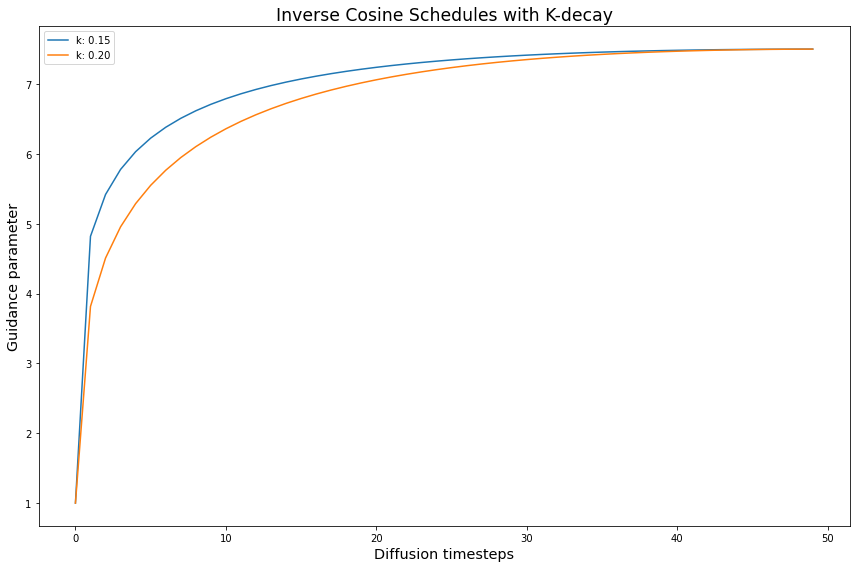

In [ ]:
#| echo: false
#| output: true
colors=list(mcolors.TABLEAU_COLORS)

# setup the plot
fig,ax = plt.subplots(figsize=(12,8))
plt.title('Inverse Cosine Schedules with K-decay', fontsize='xx-large')
plt.xlabel('Diffusion timesteps', fontsize='x-large')
plt.ylabel('Guidance parameter', fontsize='x-large')

# plot each k values
for idx,s in enumerate(inv_k_expts):
    ax.plot(s['schedule'], c=colors[idx], label=f'k: {s["val"]:.2f}')
    
plt.legend()
plt.tight_layout();

We repeat this for the `T` and `Full` Normalizations as well

In [ ]:
# create the Inverse-k-decay cosine experiments
T_inv_k_func = partial(cos_harness, default_params=DEFAULT_T_PARAMS)
T_inv_k_expts = create_expts(inv_k_params, T_inv_k_func)

# stores the inverted schedules
# invert the `k` schedules
for s in T_inv_k_expts:
    s['schedule'] = [max_T - g + min_T for g in s['schedule']]

all_T_k_expts = T_inv_k_expts

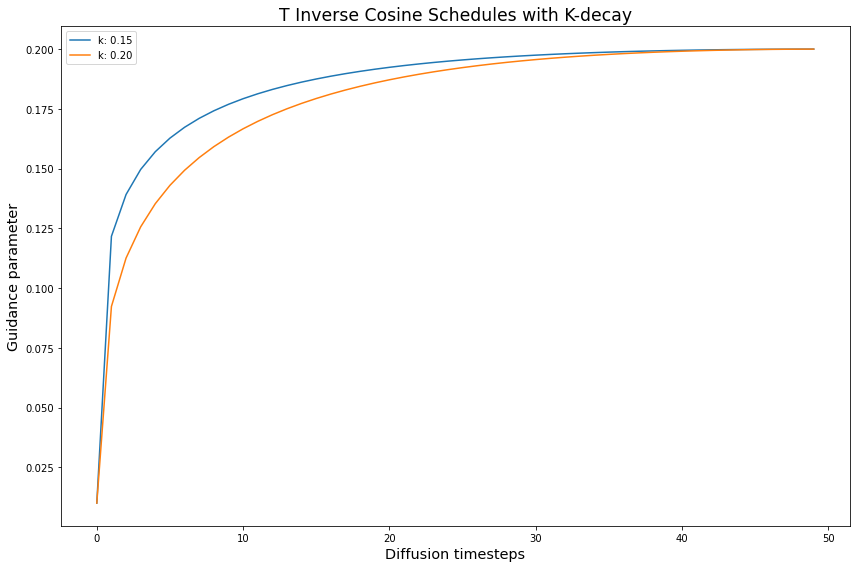

In [ ]:
#| echo: false
#| output: true
colors=list(mcolors.TABLEAU_COLORS)

# setup the plot
fig,ax = plt.subplots(figsize=(12,8))
plt.title('T Inverse Cosine Schedules with K-decay', fontsize='xx-large')
plt.xlabel('Diffusion timesteps', fontsize='x-large')
plt.ylabel('Guidance parameter', fontsize='x-large')

# plot each k values
for idx,s in enumerate(T_inv_k_expts):
    ax.plot(s['schedule'], c=colors[idx], label=f'k: {s["val"]:.2f}')
    
plt.legend()
plt.tight_layout();

# Loading different StableDiffusion models

We need to wrap our experiment pipeline in a single loop so we can easily run it with different models. To do this, we'll move the model loading code below in its own function, and add a function cleanup gpu memory.

In [ ]:
# to load Stable Diffusion pipelines
from min_diffusion.core import MinimalDiffusion

# to plot generated images
from min_diffusion.utils import show_image, image_grid, plot_grid

2022-11-25 19:37:32.852670: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


We use it to load the `Stable Diffusion v1-4` model on the GPU, with `torch.float16` precision.

In [ ]:
def load_sd_model(model_name, device, dtype, model_kwargs={}, generator=None):
    pipeline = MinimalDiffusion(model_name, device, dtype, generator=generator)
    pipeline.load(**model_kwargs);
    return pipeline

# Text prompt for image generations

We use the familiar, running prompt in our series to generate an image:  

> "a photograph of an astronaut riding a horse"

In [ ]:
# text prompt for image generations
prompt = "a photograph of an astronaut riding a horse"

## Image parameters

Images will be generated over $50$ diffusion steps. They will have a height and width of `512 x 512` pixels. 

In [ ]:
# the number of diffusion steps
num_steps = 50

# generated image dimensions
width, height = 512, 512

# Running the experiments

We modify the `run` function to now load the Stable Diffusion model internally. This makes it easy to pass in and try different generators. We add a bit of GPU cleanup at the end to make sure there is enough memory for the models. 

In [ ]:
def run(pipeline, prompt, schedules,
        guide_tfm=None, generator=None, show_each=False, test_run=False):
    """Runs a dynamic Classifier-free Guidance experiment. 
    
    Generates an image for the text `prompt` given all the values in `schedules`.
    Uses a Guidance Transformation class from the `cf_guidance` library.  
    Stores the output images with a matching title for plotting. 
    Optionally shows each image as its generated.
    If `test_run` is true, it runs a single schedule for testing. 
    """
    # store generated images and their title (the experiment name)
    images, titles = [], []
    
    # make sure we have a valid guidance transform
    assert guide_tfm
    print(f'Using Guidance Transform: {guide_tfm}')
    
    # optionally run a single test schedule
    if test_run:
        print(f'Running a single schedule for testing.')
        schedules = schedules[:1]
        
    # run all schedule experiments
    for i,s in enumerate(schedules):
        
        # parse out the title for the current run
        cur_title  = s['title']
        titles.append(cur_title)
        
        # create the guidance transformation 
        cur_sched = s['schedule']
        gtfm = guide_tfm({'g': cur_sched})
        
        print(f'Running experiment [{i+1} of {len(schedules)}]: {cur_title}...')
        img = pipeline.generate(prompt, gtfm, generator=generator)
        images.append(img)
        
        # optionally plot the image
        if show_each:
            show_image(img, scale=1)
            
    print('Done.')
    return {'images': images,
            'titles': titles}

# Gathering models and arguments

Next we create the arguments and parameters to run different models.

In [ ]:

# group the different models to run
model_expts = [

    # SD v1-4
    {'model_name': 'CompVis/stable-diffusion-v1-4',
     'model_kwargs': {'better_vae': 'ema'}},
    # SD v1-5
    {'model_name': 'runwayml/stable-diffusion-v1-5',
     'model_kwargs': {'better_vae': 'ema'}},
    # openjourney
    {'model_name': "prompthero/openjourney",
     'model_kwargs': {}},
    # SD 2-base
    {'model_name': 'stabilityai/stable-diffusion-2-base',
     'model_kwargs': {'unet_attn_slice': False}},

]

## Creating the baseline image with $G = 7.5$

First we create the baseline image using a constant Classifier-free Guidance with $G = 7.5$. Since this is a constant schedule, $k$ does not come into play.  

In [ ]:
# create the baseline schedule with the new function
baseline_g = 7.5
baseline_params = {'max_val': [baseline_g]}
baseline_func = lambda *args, **kwargs: [baseline_g for _ in range(num_steps)]
baseline_expts = create_expts(baseline_params, baseline_func)

## Improving the baseline with schedules and normalizations 

In [ ]:
outputs = {}

device = 'cuda'
dtype = torch.float16

for mparams in model_expts:
    print(f'Running model: {mparams}')
    
    model_name = mparams['model_name']
    model_kwargs = mparams['model_kwargs']
    
    # a bit of a manual patch, we need a keyword for openjourney model
    if 'openjourney' in model_name:
        cur_prompt = "mdjrny-v4 style " + prompt
    else:
        cur_prompt = prompt
    print(f'Using prompt: {cur_prompt}')
    
    # load the current Diffusion model
    pipeline = load_sd_model(model_name, device, dtype, generator=generator,
                             model_kwargs=model_kwargs)
    
    # make the baseline for this model
    baseline_res = run(pipeline, cur_prompt, baseline_expts,
                       guide_tfm=GuidanceTfm, generator=generator)
    outputs[(model_name,'baseline')] = baseline_res
    
    # generate images with different normalizations and schedules
    base_norm_res = run(pipeline, cur_prompt, all_k_expts,
                        guide_tfm=BaseNormGuidance, generator=generator)
    outputs[(model_name,'baseNorm')] = base_norm_res
                            
    T_res = run(pipeline, cur_prompt, all_T_k_expts,
                guide_tfm=TNormGuidance, generator=generator)
    outputs[(model_name,'TNorm')] = T_res

    full_res = run(pipeline, cur_prompt, all_T_k_expts,
                   guide_tfm=FullNormGuidance, generator=generator)
    outputs[(model_name,'FullNorm')] = full_res
    
    # cleanup the model for the next run
    del pipeline
    pipeline = None
    torch.cuda.empty_cache()

Running model: {'model_name': 'CompVis/stable-diffusion-v1-4', 'model_kwargs': {'better_vae': 'ema'}}
Using prompt: a photograph of an astronaut riding a horse
Using the improved VAE "ema" from stabiliy.ai
Enabling default unet attention slicing.
Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.BaseNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.TNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.FullNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Running model: {'model_name': 'runwayml/stable-diffusion-v1-5', 'model_kwargs': {'better_vae': 'ema'}}
Using prompt: a photograph of an astronaut riding a horse
Using the improved VAE "ema" from stabiliy.ai
Enabling default unet attention slicing.
Using Guidance Transform: <class 'cf_guidance.transforms.GuidanceTfm'>
Running experiment [1 of 1]: Param: "max_val", val=7.5...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.BaseNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.TNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

Running experiment [2 of 2]: Param: "k_decay", val=0.2...


  0%|          | 0/50 [00:00<?, ?it/s]

Done.
Using Guidance Transform: <class 'cf_guidance.transforms.FullNormGuidance'>
Running experiment [1 of 2]: Param: "k_decay", val=0.15...


  0%|          | 0/50 [00:00<?, ?it/s]

# Results

In [ ]:
def get_results(model_name):
    types = ['baseline', 'baseNorm', 'TNorm', 'FullNorm']
    return [outputs[(model_name,t)] for t in types]

# SD 1-4

In [ ]:
m1 = get_results('CompVis/stable-diffusion-v1-4'); m1[0]

In [ ]:
#| echo: false
#| output: true
image_grid(
    [o['images'][0] for o in m1], 
    title=[o['titles'][0] for o in m1],
    rows=2, width=width, height=height)

# SD 1-5

In [ ]:
m2 = get_results('runwayml/stable-diffusion-v1-5'); m1[0]

In [ ]:
#| echo: false
#| output: true
image_grid(
    [o['images'][0] for o in m2], 
    title=[o['titles'][0] for o in m2],
    rows=2, width=width, height=height)

# openjourney

In [ ]:
m3 = get_results('prompthero/openjourney'); m3[0]

In [ ]:
#| echo: false
#| output: true
image_grid(
    [o['images'][0] for o in m3], 
    title=[o['titles'][0] for o in m3],
    rows=2, width=width, height=height)

# SD 2

In [ ]:
m4 = get_results('stabilityai/stable-diffusion-2-base'); m4[0]

In [ ]:
#| echo: false
#| output: true
image_grid(
    [o['images'][0] for o in m4], 
    title=[o['titles'][0] for o in m4],
    rows=2, width=width, height=height)

# Conclusion